# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [124]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


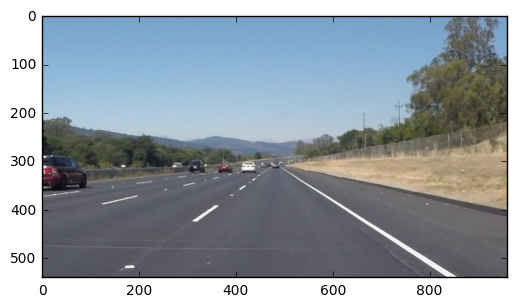

In [344]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [126]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img,lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [365]:
import os
images_list = os.listdir("test_images/")

['.DS_Store', 'solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


run your solution on all test_images and make copies into the test_images directory).

In [379]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Select image (by using a number between 1 (inclusive) and 6 (inclusive))
image_num = 1
image = mpimg.imread("test_images/" + images_list[image_num])

# Obtain the grayscale representation of the image
image_gray = grayscale(image)

# Blur(Smoothen) with a Gaussian Filter so that small discontinuities in the image (which might pose
# pose as a line by crossing the gradient min threshold in canny detection) are smoothened out.
kernel_size = 5
blur_gray = cv2.GaussianBlur(image_gray,(kernel_size, kernel_size),0)

#canny edge detection with a min threshold of 65 and max threshold of 200
image_edge = canny(blur_gray,65,200)


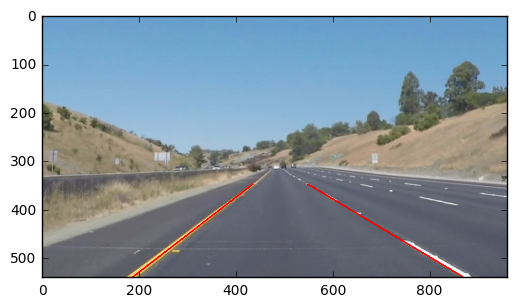

In [380]:
#Get the image dimensions to define a polygon mask that makes lane detection easier by eliminating the lines outside of region of interest
imshape = image.shape

#Define the vertices for the polygon mask
vertices = np.array([[(0,imshape[0]- 0.0*imshape[0]),(imshape[1]/2 - 100 , imshape[0]/1.55), (imshape[1]/2 + 100, imshape[0]/1.55), (imshape[1],imshape[0] - 0.0*imshape[0])]], dtype=np.int32)
#Apply the polygon mask and obtain the image with only region of interest cropped out
image_roi = region_of_interest(image_edge,vertices)


# Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 15  # maximum gap in pixels between connectable line segments

#get the hough lines and the image with the hough lines
image_line,lines = hough_lines(image_roi, rho, theta, threshold, min_line_length, max_line_gap)


#Calculate the slopes for the hough lines predicted in the image by hough transform
slopes = []
for line_list in lines:
    line = line_list[0]
    slopes.append((line[3]-line[1]) /( line[2] - line[0]))

#Based on the slopes sort the line segements, as to whether they belong to left lane or right lane.
left_lane = []
right_lane = []
index = 0
for slope in slopes:
    if slope < 0:
        left_lane.append(lines[index][0].tolist())
    elif slope > 0:
        right_lane.append(lines[index][0].tolist())
    index = index + 1

#Set parameters so as to choose best 3 (if possible) line segments for calculating the extrapolation of the line segment     
numL = min(len(left_lane),3)
numR = min(len(right_lane),3)

leftIndex =np.array(left_lane)[:,0].argsort()[-numL:][::-1]
rightIndex = np.array(right_lane)[:,0].argsort()[0:numR]

# Obtain the averaged line segment
# Now only two lines remain 
# 1)left_lane_averaged which is our best straight line estimate to the left lane
# 2)right_lane_averaged which is our best straight line estimate to the right lane
left_lane_averaged = np.average(np.array(left_lane)[leftIndex,:],axis=0)
right_lane_averaged = np.average(np.array(right_lane)[rightIndex,:],axis=0)

#Using the slopes of the lines, extend the lines to the extremeties as required

#Left Lane
left_slope = (left_lane_averaged[3]-left_lane_averaged[1])/(left_lane_averaged[2]-left_lane_averaged[0])
left_lane_averaged[0] = int(left_lane_averaged[0] - (left_lane_averaged[1] - imshape[0])/left_slope)
left_lane_averaged[1] = imshape[0]
left_lane_averaged[2] = int(left_lane_averaged[2] + (imshape[0]/1.55- left_lane_averaged[3])/left_slope)
left_lane_averaged[3] = int(imshape[0]/1.55)

#Right Lane
right_slope = (right_lane_averaged[3]- right_lane_averaged[1])/(right_lane_averaged[2]-right_lane_averaged[0])
right_lane_averaged[2] = int(right_lane_averaged[2] - (right_lane_averaged[3] - imshape[0])/right_slope)
right_lane_averaged[3] = imshape[0]
right_lane_averaged[0] = int(right_lane_averaged[0] + (imshape[0]/1.55 - right_lane_averaged[1])/right_slope)
right_lane_averaged[1] = int(imshape[0]/1.55)

#Place the LeftLane and RightLane vertices in a different list as required by the draw lines function.
lines_extended = []
lines_extended.append([left_lane_averaged])
lines_extended.append([right_lane_averaged])
lines_extended = np.array(lines_extended).astype(int)

#draw the lines on the original image
draw_lines(image,lines_extended)

#Display the orginial image with our best predicted lane marker
plt.imshow(image,cmap='gray')
mpimg.imsave("test_images/" + images_list[image_num][:-4] +"_with_lane_marking.jpg",image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [182]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [381]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Obtain the grayscale representation of the image
    image_gray = grayscale(image)
    
    # Blur(Smoothen) with a Gaussian Filter so that small discontinuities in the image (which might pose
    # pose as a line by crossing the gradient min threshold in canny detection) are smoothened out.
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(image_gray,(kernel_size, kernel_size),0)
    
    #canny edge detection with a min threshold of 65 and max threshold of 200
    image_edge = canny(blur_gray,65,200)

    #Get the image dimensions to define a polygon mask that makes lane detection easier by eliminating the lines outside of region of interest
    imshape = image.shape
    
    #Define the vertices for the polygon mask
    vertices = np.array([[(0,imshape[0]- 0.0*imshape[0]),(imshape[1]/2 - 100 , imshape[0]/1.55), (imshape[1]/2 + 100, imshape[0]/1.55), (imshape[1],imshape[0] - 0.0*imshape[0])]], dtype=np.int32)
    
    #Apply the polygon mask and obtain the image with only region of interest cropped out
    image_roi = region_of_interest(image_edge,vertices)


    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 30     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 15  # maximum gap in pixels between connectable line segments
    
    #get the hough lines and the image with the hough lines
    image_line,lines = hough_lines(image_roi, rho, theta, threshold, min_line_length, max_line_gap)

    #Calculate the slopes for the hough lines predicted in the image by hough transform
    slopes = []
    for line_list in lines:
        line = line_list[0]
        slopes.append((line[3]-line[1]) /( line[2] - line[0]))

    #Based on the slopes sort the line segements, as to whether they belong to left lane or right lane.
    left_lane = []
    right_lane = []
    index = 0
    for slope in slopes:
        if slope < 0:
            left_lane.append(lines[index][0].tolist())
        elif slope > 0:
            right_lane.append(lines[index][0].tolist())
        index = index + 1
        
    #Set parameters so as to choose best 3 (if possible) line segments for calculating the extrapolation of the line segment
    numL = min(len(left_lane),3)
    numR = min(len(right_lane),3)

    leftIndex =np.array(left_lane)[:,0].argsort()[-numL:][::-1]
    rightIndex = np.array(right_lane)[:,0].argsort()[0:numR]
    
    # Obtain the averaged line segment
    # Now only two lines remain 
    # 1)left_lane_averaged which is our best straight line estimate to the left lane
    # 2)right_lane_averaged which is our best straight line estimate to the right lane
    
    left_lane_averaged = np.average(np.array(left_lane)[leftIndex,:],axis=0)
    right_lane_averaged = np.average(np.array(right_lane)[rightIndex,:],axis=0)

    #Using the slopes of the lines, extend the lines to the extremeties as required
    
    #Left Lane
    left_slope = (left_lane_averaged[3]-left_lane_averaged[1])/(left_lane_averaged[2]-left_lane_averaged[0])
    left_lane_averaged[0] = int(left_lane_averaged[0] - (left_lane_averaged[1] - imshape[0])/left_slope)
    left_lane_averaged[1] = imshape[0]
    left_lane_averaged[2] = int(left_lane_averaged[2] + (imshape[0]/1.55- left_lane_averaged[3])/left_slope)
    left_lane_averaged[3] = int(imshape[0]/1.55)

    #Right Lane
    right_slope = (right_lane_averaged[3]- right_lane_averaged[1])/(right_lane_averaged[2]-right_lane_averaged[0])
    right_lane_averaged[2] = int(right_lane_averaged[2] - (right_lane_averaged[3] - imshape[0])/right_slope)
    right_lane_averaged[3] = imshape[0]
    right_lane_averaged[0] = int(right_lane_averaged[0] + (imshape[0]/1.55 - right_lane_averaged[1])/right_slope)
    right_lane_averaged[1] = int(imshape[0]/1.55)
    
    #Place the LeftLane and RightLane vertices in a different list as required by the draw lines function.
    lines_extended = []
    lines_extended.append([left_lane_averaged])
    lines_extended.append([right_lane_averaged])
    lines_extended = np.array(lines_extended).astype(int)
    
    #draw the lines on the original image
    draw_lines(image,lines_extended)
    
    #return the orginial image with our best predicted lane marker
    return image

Let's try the one with the solid white lane on the right first ...

In [382]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 86.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.11 s, sys: 791 ms, total: 2.9 s
Wall time: 2.96 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [161]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [383]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:08<00:00, 81.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 6.69 s, sys: 2.44 s, total: 9.14 s
Wall time: 8.64 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


For making the algorithm better/robust, I was thinking that we can store the previously chosen lane marker and compare the current determined lane marker to the previously chosen marker in terms of its slope. If the current lane marker deviates from the previous by a margin greater than our threshold, then we dont consider the current one as a valid marker and continue with the previous one and we wait for the next frame to evaluate the lane marker from it (next frame).I was not sure about whether saving the state of the lanes and using it for the future frame's lane marker evaluation was allowed for this assignment.

The algorithm assumes that whicever line segments that are reported in the region of interest image, are all valid line segments. This is sort of fair under normal conditions, since we have tuned our polygon w.r.t to the camera placement such that only valid current lane markings turn up as line segments in the region of interest image. But, this goes for a toss, for example in the challenge video, when the vehicles approaches a, sort of a cement path of road, where it becomes difficult to detect the lane marking. Here, with my current implementation, the lanes go crazy for some frames, and for some frames, the left wall is detected as a lane. Again, if this patch of road is for a shorter duration, I think my above idea of preserving previous lane parameters and continuing with the previous lane parameters to eliminate the short erratic lane markings could work reasonably in this situation.

For the challenge video, the placement of the camera is different. Here, the bottom 10-15% of the image is blocked by the front of the car. Under the assumption that we write a lane detection system for a specific configuration, and certain parameters of the code are tailored  as per the configuration of the car, in terms of camera placment affecting the field of view etc., I have a made a new function process_image2 for the challenge video. 
Here, I take extra care to see that, the video is gotten rid of the front of the car by constructing the polygon such that the bottom 15% of the image is discarded in region of interest determination. This helped my detection extensively. Further, because of the harsher road conditions in this video, during the cement patch part, the line segments are very erratic. To take care of this, I have made the passing criterion for a line segment to qualify as a valid contributor to the left or right lane markings much stricter, which is reflected in the slope parameters being thresholded at higher values compared to the default zero threshold for the above two videos.
This, thershold adjustment, coupled with the region of interest adjustment, made my lane detections much more accurate for the challenge video.


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [384]:
def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Obtain the grayscale representation of the image
    image_gray = grayscale(image)
    
    # Blur(Smoothen) with a Gaussian Filter so that small discontinuities in the image (which might pose
    # pose as a line by crossing the gradient min threshold in canny detection) are smoothened out.
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(image_gray,(kernel_size, kernel_size),0)
    
    #canny edge detection with a min threshold of 65 and max threshold of 200
    image_edge = canny(blur_gray,65,200)
    
    #Get the image dimensions to define a polygon mask that makes lane detection easier by eliminating the lines outside of region of interest
    imshape = image.shape
    
    #Define the vertices for the polygon mask
    #The image is adjusted so that the front of the car which block bottom 15% of the image is removed from region of interst
    vertices = np.array([[(0,imshape[0]- 0.15*imshape[0]),(imshape[1]/2 - 50 , imshape[0]/1.55), (imshape[1]/2 + 50, imshape[0]/1.55), (imshape[1],imshape[0] - 0.15*imshape[0])]], dtype=np.int32)
    
    #Apply the polygon mask and obtain the image with only region of interest cropped out
    image_roi = region_of_interest(image_edge,vertices)
    

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold =25     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 15  # maximum gap in pixels between connectable line segments

    #get the hough lines and the image with the hough lines
    image_line,lines = hough_lines(image_roi, rho, theta, threshold, min_line_length, max_line_gap)

    #Calculate the slopes for the hough lines predicted in the image by hough transform
    slopes = []
    for line_list in lines:
        line = line_list[0]
        slopes.append((line[3]-line[1]) /( line[2] - line[0]))

    #Based on the slopes sort the line segements, as to whether they belong to left lane or right lane.
    left_lane = []
    right_lane = []
    index = 0
    for slope in slopes:
        if slope < -0.3:
            left_lane.append(lines[index][0].tolist())
        elif slope > 0.4: 
            right_lane.append(lines[index][0].tolist())
        index = index + 1
        
    #Set parameters so as to choose best 3 (if possible) line segments for calculating the extrapolation of the line segment 
    numL = min(len(left_lane),3)
    numR = min(len(right_lane),3)
   
    leftIndex =np.array(left_lane)[:,0].argsort()[-numL:][::-1]
    rightIndex = np.array(right_lane)[:,0].argsort()[0:numR]
    
    
    # Obtain the averaged line segment
    # Now only two lines remain 
    # 1)left_lane_averaged which is our best straight line estimate to the left lane
    # 2)right_lane_averaged which is our best straight line estimate to the right lane
    
    left_lane_averaged = np.average(np.array(left_lane)[leftIndex,:],axis=0)
    right_lane_averaged = np.average(np.array(right_lane)[rightIndex,:],axis=0)

    #Using the slopes of the lines, extend the lines to the extremeties as required
    
    #Left Lane
    left_slope = (left_lane_averaged[3]-left_lane_averaged[1])/(left_lane_averaged[2]-left_lane_averaged[0])
    left_lane_averaged[0] = int(left_lane_averaged[0] - (left_lane_averaged[1] - imshape[0])/left_slope)
    left_lane_averaged[1] = imshape[0]
    left_lane_averaged[2] = int(left_lane_averaged[2] + (imshape[0]/1.55- left_lane_averaged[3])/left_slope)
    left_lane_averaged[3] = int(imshape[0]/1.55)

    #Right Lane
    right_slope = (right_lane_averaged[3]- right_lane_averaged[1])/(right_lane_averaged[2]-right_lane_averaged[0])
    right_lane_averaged[2] = int(right_lane_averaged[2] - (right_lane_averaged[3] - imshape[0])/right_slope)
    right_lane_averaged[3] = imshape[0]
    right_lane_averaged[0] = int(right_lane_averaged[0] + (imshape[0]/1.55 - right_lane_averaged[1])/right_slope)
    right_lane_averaged[1] = int(imshape[0]/1.55)
    
    #Place the LeftLane and RightLane vertices in a different list as required by the draw lines function.
    lines_extended = []
    lines_extended.append([left_lane_averaged])
    lines_extended.append([right_lane_averaged])
    lines_extended = np.array(lines_extended).astype(int)
    
    #draw the lines on the original image
    draw_lines(image,lines_extended)

    #return the orginial image with our best predicted lane marker
    return image

In [385]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:05<00:00, 44.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 3.74 s, sys: 886 ms, total: 4.63 s
Wall time: 6.51 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))